In [13]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Firstly, let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [14]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 1.  [Perturbative Black Box VI](https://arxiv.org/abs/1709.07433)

Consider the quantity $$ V(\boldsymbol{\theta}; \boldsymbol{\phi}) = -\log p(\mathbf{X}, \boldsymbol{\theta}) + \log q(\boldsymbol{\theta}; \boldsymbol{\phi}),$$ which is just the negative of the [*evidence lower bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf) without the enclosing expectation (i.e. $\log p(\mathbf{X}) \ge \mathbb{E}_{q}[- V(\boldsymbol{\theta}; \boldsymbol{\phi})]$).  Perturbative black box variational inference (PBBVI) considers the quantity: $$ p(\mathbf{X}) = \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ f(e^{- V(\boldsymbol{\theta}; \boldsymbol{\phi})})].$$  When $f$ is the identity function, the objective becomes [an importance weighted estimate of the evidence](https://arxiv.org/abs/1509.00519), and when $f$ is $\log$, then the ELBO is recovered.  Things get interesting when we consider functions between the aforementioned two, which will result in an objective that is tighter than the ELBO and lower variance than the importance sampled estimate.  Bamler et al. propose using an odd-ordered Taylor expansion around some point $V_{0}$.  For order three, we have: $$ p(\mathbf{X}) \ge e^{-V_{0}} \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ 1 + (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi})) + \frac{1}{2} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{2} + \frac{1}{6} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{3} ].$$  $V(\boldsymbol{\theta}; \boldsymbol{\phi})$ enters the equation polynomially, not exponentially, and thus a Monte Carlo estimate of the objective has lower variance than the importance sampled direct estimate (i.e. when $f$ is the identity).  

## 2.  Experiment: Predictive Uncertainty

Next we'll examine how PBBVI performs in model uncertainty in a regression setting...

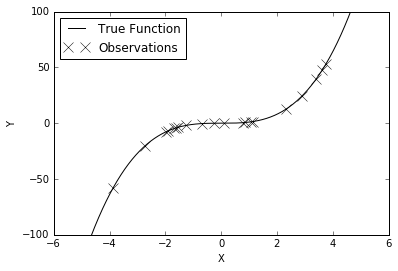

In [15]:
# Simulate data
N = 20
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
x_true = np.linspace(start=-6, stop=6, num=1000)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-', label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

Below we define the necessary functions and their gradients...

In [16]:
# Gaussian prior and posterior
prior = {'mu': 0., 'sigma':.0001}

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e

def logGaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return np.sum(np.log(1./np.sqrt(2*np.pi*params['sigma']**2)) + ((-.5/params['sigma']**2) * (x-params['mu'])**2))

# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * (y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]

# Gauss-to-Gauss KLD
def gaussKLD(mu, log_sigma, prior_mu=prior['mu'], prior_sigma=prior['sigma']):
    kl = -np.log(prior_sigma**2)
    kl += -(np.exp(2*log_sigma) + (mu - prior_mu)**2)/(prior_sigma**2)
    kl += 2*log_sigma + 1.
    return -0.5*kl.mean()


### GET DERIVATIVES ###

# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

# d log p(\theta) / d \theta
dLogGauss_dX = grad(lambda x, mu, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dMu = grad(lambda mu, x, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dLogSig = grad(lambda log_sigma, x, mu: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))

# d entropy / d log_sigma
dKLD_dmu = grad(gaussKLD)
dKLD_dLogSigma = grad(lambda p1, p2: gaussKLD(p2, p1))

###  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via the ELBO...

In [17]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 'b': np.zeros((1,51))}


### ELBO OPTIMIZATION
maxEpochs = 200
learning_rate = .01
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        elbo_grad_mu += 1./n_samples * dModel_dW * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dW * rand_seed * np.exp(phi['log_sigma'])
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        elbo_val += 1./n_samples * logModel(W_hat, phi['b'], x, y)
        
    elbo_grad_mu -= dKLD_dmu(phi['mu'], phi['log_sigma'])  
    elbo_grad_log_sigma -= dKLD_dLogSigma(phi['log_sigma'], phi['mu'])
    elbo_val -= gaussKLD(phi['mu'], phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu , adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

And get an MC estimate of the predictive uncertainty...

In [18]:
n_samples = 500
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
elbo_pred_mean = np.mean(predictions, axis=0)
elbo_pred_std = np.std(predictions, axis=0)

###  Variational Inference via PBBVI

Next let's fit the same Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--but via the third-order perturbative BBVI bound.  Note we need to optimize $V_{0}$ in addition to the variational parameters...

In [19]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 
       'V0': 0., 'b': np.zeros((1,51))}


### PBBVI OPTIMIZATION
#maxEpochs = 200
#learning_rate = .001
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'V0':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    negV_val, negV_grad_mu, negV_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        negV_grad_mu += 1./n_samples * ((dModel_dW + dLogGauss_dX(W_hat, prior['mu'], np.log(prior['sigma']))) * 1. \
                                        - dLogGauss_dMu(phi['mu'], W_hat, phi['log_sigma']))
        negV_grad_log_sigma += 1./n_samples * ((dModel_dW + dLogGauss_dX(W_hat, prior['mu'], np.log(prior['sigma']))) * rand_seed * np.exp(phi['log_sigma']) \
                                               - dLogGauss_dLogSig(phi['log_sigma'], W_hat, phi['mu']))
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        
        negV_val += 1./n_samples * (logModel(W_hat, phi['b'], x, y) \
                                    + logGaussPdf(W_hat, prior) \
                                    - logGaussPdf(W_hat, {'mu': phi['mu'], 'sigma': np.exp(phi['log_sigma'])}))
        
    
    # gradient for V0: \tilde L / V0 - \tilde V0 (see Section 3.2)
    tilde_L = 1 + (phi['V0'] + negV_val) + 1./2 * (phi['V0'] + negV_val)**2 + 1./6 * (phi['V0'] + negV_val)**3
    dtildeL_dV0 = 1 + (phi['V0'] + negV_val) + 1./2 * (phi['V0'] + negV_val)**2
    ppvi_grad_V0 = dtildeL_dV0 - tilde_L
    
    # gradient for \mu and \log_sigma
    ppvi_grad_mu = negV_grad_mu + (phi['V0'] + negV_val) * negV_grad_mu + .5 * (phi['V0'] + negV_val)**2 * negV_grad_mu
    ppvi_grad_log_sigma = negV_grad_log_sigma + (phi['V0'] + negV_val) * negV_grad_log_sigma + .5 * (phi['V0'] + negV_val)**2 * negV_grad_log_sigma
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
    phi['V0'] += get_AdaM_update(learning_rate, ppvi_grad_V0, adam_values['V0'])
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

And get an MC estimate of the predictive uncertainty...

In [20]:
n_samples = 500
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
pbbvi_pred_mean = np.mean(predictions, axis=0)
pbbvi_pred_std = np.std(predictions, axis=0)

Lastly, let's visualize the uncertainty bands...

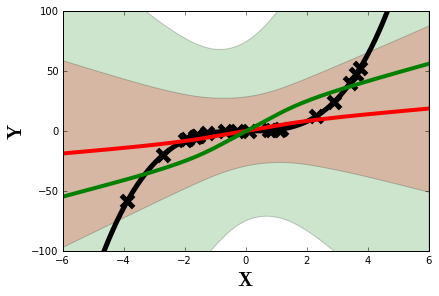

In [21]:
### Plotting ###    
plt.fill_between(x_true, pbbvi_pred_mean-2.*pbbvi_pred_std, pbbvi_pred_mean+2.*pbbvi_pred_std, facecolor='green', interpolate=True, alpha=.2)
plt.fill_between(x_true, elbo_pred_mean-2.*elbo_pred_std, elbo_pred_mean+2.*elbo_pred_std, facecolor='red', interpolate=True, alpha=.2)
plt.scatter(x, y, s=150, c='k', marker='x', linewidths=5)
plt.plot(x_true, y_true, '-k', linewidth=5.)
plt.plot(x_true, elbo_pred_mean, 'r-', linewidth=4.)
plt.plot(x_true, pbbvi_pred_mean, 'g-', linewidth=4.)

plt.xlim([-6, 6])
plt.ylim([-100, 100])
plt.ylabel(r"$\mathbf{Y}$", fontsize=20)
plt.xlabel(r"$\mathbf{X}$", fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

We see that, indeed, PBBVI seems to learn a better fit and larger uncertainty bands.